In [91]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import random
import matplotlib.pyplot as plt

In [92]:
device = 'cuda'

In [93]:
torch.cuda.is_available()

True

In [94]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)


In [120]:
batch_size = 128
epochs = 10
learning_rate = 3e-6
patch_size = 4
num_classes = 10
image_size = 32
channels = 3
embed_dim = 256
num_heads = 8
depth = 6
mlp_dim = 512
drop_rate = 0.1


In [96]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandAugment(num_ops=2, magnitude=9),   # <-- NEW
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


In [97]:
train_dataset = datasets.CIFAR10(root='data',
                                 train=True,
                                 download=True,
                                 transform=transform_train)


Files already downloaded and verified


In [98]:
test_dataset = datasets.CIFAR10(
    root='data',
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5),(0.5))
    ])
)


Files already downloaded and verified


In [99]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=True)

In [100]:
print(f"Length of train_loader: {len(train_loader)} batches of {batch_size}...")
print(f"Length of test_loader: {len(test_loader)} batches of {batch_size}...")

Length of train_loader: 391 batches of 128...
Length of test_loader: 79 batches of 128...


In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, embed_dim):
        super().__init__()
        self.patch_size = patch_size

        # 2-layer conv patch embed (Conv stem)
        self.proj = nn.Sequential(
            nn.Conv2d(in_channels, embed_dim // 2,
                      kernel_size=patch_size, stride=patch_size),
            nn.GELU(),
            nn.Conv2d(embed_dim // 2, embed_dim, kernel_size=1)
        )

        num_patches = (img_size // patch_size) ** 2
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim))

    def forward(self, x):
        B = x.size(0)
        x = self.proj(x)                      # (B, E, H/P, W/P)
        x = x.flatten(2).transpose(1, 2)      # (B, N, E)

        cls_token = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x = x + self.pos_embed
        return x
    


In [102]:
class MLP(nn.Module):

    def __init__(self, in_features, hidden_features, drop_rate):
        super().__init__()
        self.fc1 = nn.Linear(in_features=in_features, 
                            out_features=hidden_features)
        self.fc2 = nn.Linear(in_features=hidden_features,
                             out_features=in_features)
        self.dropout = nn.Dropout(drop_rate)

    def forward(self, x:torch.tensor):
        x = self.dropout(F.gelu(self.fc1(x)))
        x = self.dropout(self.fc2(x))
        return x
    

In [103]:
from timm.models.layers import DropPath


class TransformerEncoderLayer(nn.Module):
    
    def __init__(self, embed_dim, num_heads, mlp_dim, drop_rate, drop_path_rate=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, 
                                          dropout=drop_rate, batch_first=True)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = MLP(embed_dim, mlp_dim, drop_rate)
        self.drop_path = DropPath(drop_path_rate) if drop_path_rate > 0 else nn.Identity()

    def forward(self, x):
        attn_out = self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0]
        x = x + self.drop_path(attn_out)

        mlp_out = self.mlp(self.norm2(x))
        x = x + self.drop_path(mlp_out)
        
        return x
    

In [104]:
class VisionTransformer(nn.Module):

    def __init__(self, img_size, patch_size,in_channels,num_classes,
                 embed_dim, depth, num_heads, mlp_dim, drop_rate):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.encoder = nn.Sequential(*[
            TransformerEncoderLayer(embed_dim, num_heads, mlp_dim, drop_rate, drop_path_rate=0.1) for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self,x):
        x = self.patch_embed(x)
        x = self.encoder(x)
        x = self.norm(x)
        cls_token = x[:,0]
        return self.head(cls_token)
        


In [105]:
class WarmupCosineLR:
    def __init__(self, optimizer, warmup_epochs, max_epochs, base_lr):
        self.optimizer = optimizer
        self.warmup_epochs = warmup_epochs
        self.max_epochs = max_epochs
        self.base_lr = base_lr

    def step(self, epoch):
        # Warmup phase
        if epoch < self.warmup_epochs:
            lr = self.base_lr * (epoch + 1) / self.warmup_epochs
        else:
            # Cosine decay phase
            t = epoch - self.warmup_epochs
            T = self.max_epochs - self.warmup_epochs
            lr = 0.5 * self.base_lr * (1 + np.cos(np.pi * t / T))

        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr


In [106]:
model = VisionTransformer(
    image_size, patch_size, channels, num_classes,
    embed_dim, depth, num_heads, mlp_dim, drop_rate
).to(device)

In [121]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=learning_rate,
    weight_decay=0.05
)

warmup_epochs = 2
scheduler = WarmupCosineLR(
    optimizer,
    warmup_epochs=warmup_epochs,
    max_epochs=epochs,
    base_lr=learning_rate
)


In [108]:
def train(model, loader, optimizer, criterion):
    model.train()
    total_loss, correct = 0, 0

    for x,y in loader:
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out,y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        correct += (out.argmax(1) == y).sum().item()

    return total_loss / len(loader.dataset), correct / len(loader.dataset)

        

In [109]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    with torch.inference_mode():
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            out = model(x)
            correct += (out.argmax(1) == y).sum().item()
    return correct / len(loader.dataset)

In [110]:
from tqdm.auto import tqdm
train_accuracies, test_accuracies = [],[]

In [122]:


for epoch in tqdm(range(5)):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    test_acc = evaluate(model, test_loader)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    scheduler.step(epoch)
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch: {epoch+1}/{epochs}, Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1/10, Train loss: 1.1415, Train acc: 0.5923, Test acc: 0.6666
Epoch: 2/10, Train loss: 1.1328, Train acc: 0.5978, Test acc: 0.6695
Epoch: 3/10, Train loss: 1.1209, Train acc: 0.6015, Test acc: 0.6733
Epoch: 4/10, Train loss: 1.1073, Train acc: 0.6051, Test acc: 0.6743
Epoch: 5/10, Train loss: 1.1067, Train acc: 0.6074, Test acc: 0.6756


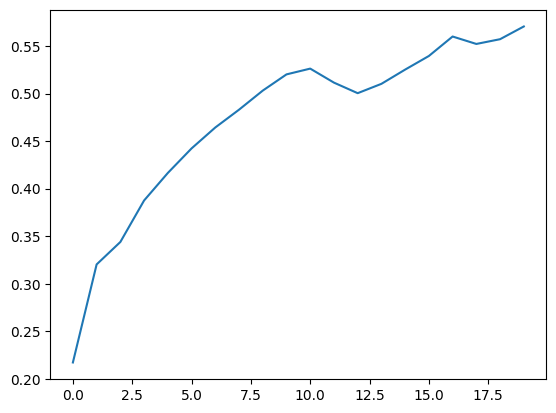

In [116]:
plt. plot(train_accuracies)

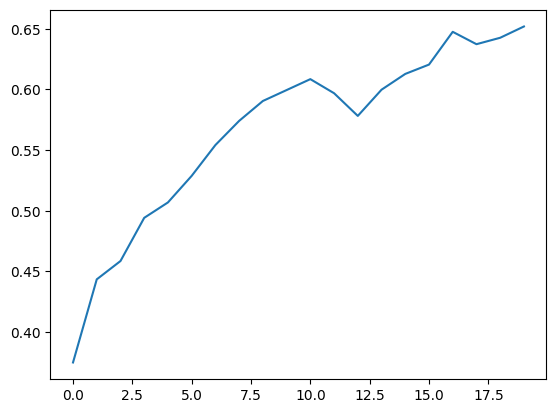

In [117]:
plt.plot(test_accuracies)

• Rewrite the entire code into a clean .py version for your repo
• Add comments + structure
• Add a config system
• Add the improved ViT (with stochastic depth, cosine schedule, RandAugment)
• Add a training log + visualization tools
• Show you how to checkpoint models
• Show you how to evaluate per-class accuracy
• Show you how to convert this into a real “vision-models” project

In [28]:
train_accuracies

[0.59158, 0.6029, 0.61428, 0.6246, 0.63678]

In [21]:
test_dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

In [118]:
import random

def predict_and_plot_grid(model, dataset, classes, grid_size):
    model.eval() 
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(9,9))
    for i in range(grid_size):
        for j in range(grid_size):
            idx = random.randint(0, len(dataset) - 1) 
            img, true_label = dataset[idx]      
            input_tensor = img.unsqueeze(dim=0).to(device)   
            with torch.inference_mode():
                output = model(input_tensor)
                _, predicted = torch.max(output.data, 1)
            img = img / 2 + 0.5  #denormalize
            npimg = img.cpu().numpy()
            axes[i,j].imshow(np.transpose(npimg, (1,2,0)))
            truth = classes[true_label] == classes[predicted.item()]
            if truth:
                color = "g"
            else:
                color = "r"
            axes[i,j].set_title(f"Tr: {classes[true_label]}\n, Pr: {classes[predicted.item()]}", fontsize=10, c=color)
            axes[i,j].axis('off')
    plt.tight_layout()
    plt.show()


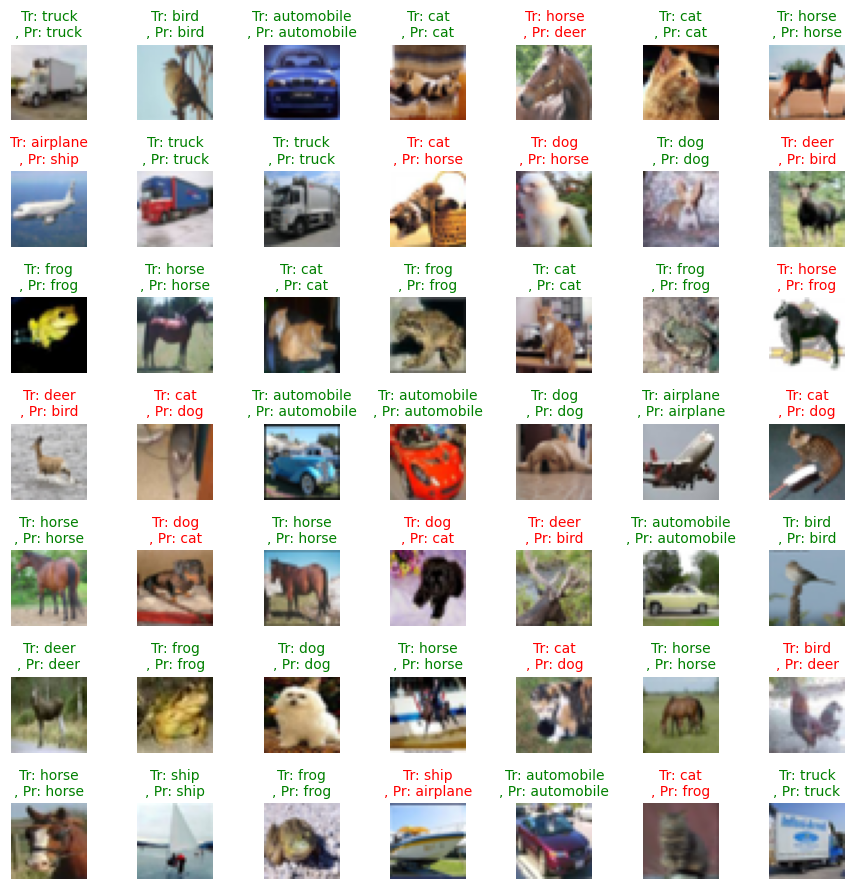

In [119]:
predict_and_plot_grid(model, test_dataset, classes=train_dataset.classes, grid_size=7)

positional encoding deeply

training stabilization

dropout variations

multimodal embeddings

learning rate schedules

=============================

fix data pipeline

add stochastic depth

improve positional embeddings

improve training loop

add cosine warmup

add attention visualization

add checkpoint saving

add a proper README

push everything cleanly to vision-models

🔥 Cosine Learning Rate Schedule → +2–4%
🔥 Warmup → stabilizes early training
🔥 Cutout or RandomErasing
🔥 Mixup or CutMix
🔥 Patch dropout (stochastic depth on tokens)
🔥 Better patch embedding (Conv stem)

In [123]:
from PIL import Image
import torchvision.transforms as transforms


In [124]:
inference_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


In [162]:
img = Image.open("/home/kiran/Desktop/horse.webp").convert("RGB")


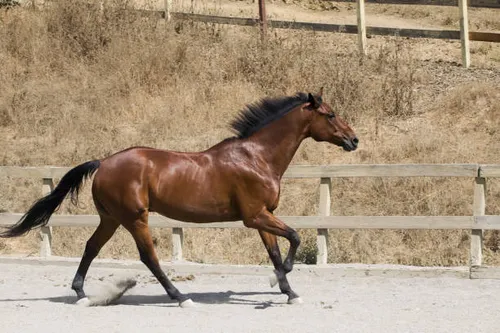

In [163]:
img

In [164]:
input_tensor = inference_transform(img).unsqueeze(0).to(device)


In [165]:
input_tensor.shape
im = input_tensor.squeeze(0).permute(2,1,0)
im.shape

torch.Size([32, 32, 3])

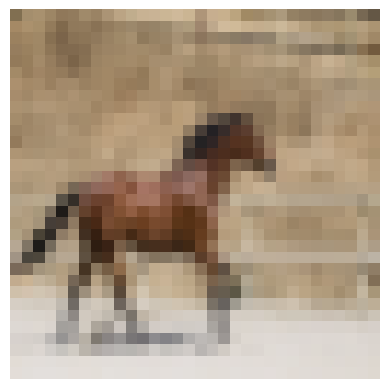

In [166]:
import matplotlib.pyplot as plt
import numpy as np

# Remove batch dimension
vis_img = input_tensor.squeeze(0)

# Undo normalization
vis_img = vis_img * 0.5 + 0.5

# CHW → HWC
vis_img = vis_img.permute(1, 2, 0).cpu().numpy()

# Plot
plt.imshow(vis_img)
plt.axis("off")
plt.show()


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

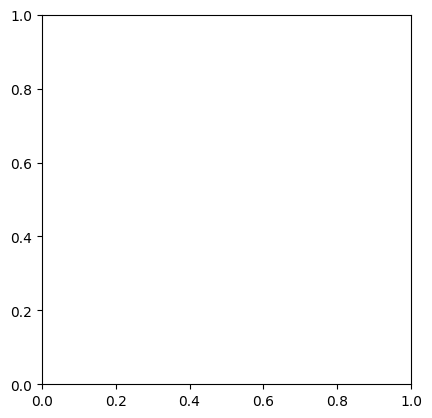

In [167]:
plt.imshow(im)

In [168]:
# Apply transform
input_tensor = inference_transform(img).unsqueeze(0).to(device)

# Run inference
model.eval()
with torch.inference_mode():
    logits = model(input_tensor)
    pred_idx = logits.argmax(1).item()

# CIFAR-10 classes
classes = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

print("Predicted class:", classes[pred_idx])

Predicted class: horse


In [1]:
model

NameError: name 'model' is not defined